In [2]:
#9


import os
from glob import glob

import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


def parse_free_digits(directory):
    # Parse relevant dataset info
    files = glob(os.path.join(directory, "*.wav"))
    
    fnames = [f.split("\\")[1].split(".")[0].split("_") for f in files]
    
    ids = [f[2] for f in fnames]
    y = [int(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]
    _, Fs = librosa.core.load(files[0], sr=None)

    def read_wav(f):
        wav, _ = librosa.core.load(f, sr=None)

        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    # Print dataset info
    print("Total wavs: {}. Fs = {} Hz".format(len(wavs), Fs))

    return wavs, Fs, ids, y, speakers


def extract_features(wavs, n_mfcc=6, Fs=8000):
    # Extract MFCCs for all wavs
    window = 30 * Fs // 1000
    step = window // 2
    frames = [
        librosa.feature.mfcc(
            wav, Fs, n_fft=window, hop_length=window - step, n_mfcc=n_mfcc
        ).T

        for wav in tqdm(wavs, desc="Extracting mfcc features...")
    ]

    print("Feature extraction completed with {} mfccs per frame".format(n_mfcc))

    return frames


def split_free_digits(frames, ids, speakers, labels):
    print("Splitting in train test split using the default dataset split")
    # Split to train-test
    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ["0", "1", "2", "3", "4"]
    
    for idx, frame, label, spk in zip(ids, frames, labels, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test


def make_scale_fn(X_train):
    # Standardize on train data
    scaler = StandardScaler()
    scaler.fit(np.concatenate(X_train))
    print("Normalization will be performed using mean: {}".format(scaler.mean_))
    print("Normalization will be performed using std: {}".format(scaler.scale_))
    def scale(X):
        scaled = []

        for frames in X:
            scaled.append(scaler.transform(frames))
        return scaled
    return scale


def parser(directory, n_mfcc=6):
    wavs, Fs, ids, y, speakers = parse_free_digits(directory)
    frames = extract_features(wavs, n_mfcc=n_mfcc, Fs=Fs)
    make_scale_fn(frames)
#     print(len(frames))
#     print(len(ids))
#     print(len(y))
#     print(len(speakers))
    X_train, X_test, y_train, y_test, spk_train, spk_test = split_free_digits(
        frames, ids, speakers, y
    )

    return X_train, X_test, y_train, y_test, spk_train, spk_test

In [3]:
X_train, X_test, y_train, y_test, spk_train, spk_test = parser("recordings")

Total wavs: 3000. Fs = 8000 Hz


Extracting mfcc features...: 100%|████████████████████████████████████████████████| 3000/3000 [00:15<00:00, 195.37it/s]


Feature extraction completed with 6 mfccs per frame
Normalization will be performed using mean: [-517.71365072   62.17300245   19.0018117     9.6444396   -19.211481
  -10.88157066]
Normalization will be performed using std: [152.11675796  52.36822505  36.82452713  29.71210521  24.82190463
  23.43786656]
Splitting in train test split using the default dataset split


In [4]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.20) 
#stratify to make sure we have the same analogy

print(len(X_tr))
print(len(X_val))
print(len(X_test))

2160
540
300


In [7]:
#10
#necessary for model training/testing cause shapes don't fit otherwise
digits_tr = [0,0,0,0,0,0,0,0,0,0]

for i in range(len(X_tr)):
    if (type(digits_tr[y_tr[i]]) == int): 
        digits_tr[y_tr[i]] = X_tr[i]  #all instances of the same digit
    else:
        digits_tr[y_tr[i]] = np.concatenate((digits_tr[y_tr[i]], X_tr[i]), axis=0)

        
digits_val=[0,0,0,0,0,0,0,0,0,0]

for i in range(len(X_val)):
    if (type(digits_val[y_val[i]]) == int): 
        digits_val[y_val[i]] = X_val[i]
    else:
        digits_val[y_val[i]] = np.concatenate((digits_val[y_val[i]], X_val[i]), axis=0)
        
        
digits_test=[0,0,0,0,0,0,0,0,0,0]

for i in range(len(X_test)):
    if (type(digits_test[y_test[i]]) == int): 
        digits_test[y_test[i]] = X_test[i]
    else:
        digits_test[y_test[i]] = np.concatenate((digits_test[y_test[i]], X_test[i]), axis=0)
        
        
        
#its dimension would be num_sequences x seq_length x feature_dimension  ?      
digits_train_3 = [[], [], [], [], 
                   [], [], [], [], 
                   [], []]

for i in range(len(X_tr)):
    digits_train_3[y_tr[i]].append(np.array(X_tr[i]))

digits_val_3 = [[], [], [], [], 
                [], [], [], [], 
                [], []]

for i in range(len(X_val)):
    digits_val_3[y_val[i]].append(np.array(X_val[i]))
    
    
digits_test_3 = [[], [], [], [], 
                [], [], [], [], 
                [], []]

for i in range(len(X_test)):
    digits_test_3[y_test[i]].append(np.array(X_test[i]))

In [8]:
#modified the given code
import numpy as np

from pomegranate import *

n_states = 4 # the number of HMM states
n_mixtures = 3 # the number of Gaussians
gmm = True # whether to use GMM or plain Gaussian
gmm_hmm=[]

for i in range(10):
    Xi = np.array(digits_tr[i],dtype='float64')# data from a single digit (can be a numpy array)
    dists = [] # list of probability distributions for the HMM states

    for i in range(n_states):
        if gmm:
            a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, n_mixtures, Xi)
        else:
            a = MultivariateGaussianDistribution.from_samples(Xi)
        dists.append(a)

    trans_mat = np.array([[0.5,0.5,0,0],[0,0.5,0.5,0],[0,0,0.5,0.5],[0,0,0,1]]) #your transition matrix aij=0 for j<i & j>i+1, 0.5 default initialization
    starts = np.array([1,0,0,0]) # your starting probability matrix
    ends = [] # your ending probability matrix #unknown for now

    #data = [] # your data: must be a Python list that contains: 2D lists with the sequences (so its dimension would be num_sequences x seq_length x feature_dimension)
              # But be careful, it is not a numpy array, it is a Python list (so each sequence can have different length)

    # Define the GMM-HMM
    model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends, state_names=['s{}'.format(j) for j in range(n_states)])
    gmm_hmm.append(model)
    


In [9]:
#11 fitting
for i in range(10):
    gmm_hmm[i].fit(digits_train_3[i].copy(),algorithm='baum-welch') #baum-welch is EM
    


In [10]:
#12
#max log likelihood with viterbi algorithm
#on validation set
y_val_predictions=np.zeros(len(X_val),dtype='int')
for i in range(len(X_val)):
    logprob=-10000
    for digit in range(10):
        log1,tups=gmm_hmm[digit].viterbi(X_val[i].copy())
        if log1>logprob:
            logprob=log1
            y_val_predictions[i]=digit
y_val_predictions=list(y_val_predictions)            
print(y_val_predictions)
print(y_val)

[0, 0, 3, 0, 3, 0, 2, 7, 6, 6, 3, 2, 9, 0, 9, 4, 5, 9, 9, 2, 7, 3, 6, 7, 9, 9, 3, 3, 8, 9, 7, 5, 1, 7, 9, 5, 9, 8, 0, 8, 2, 0, 6, 2, 9, 2, 6, 8, 8, 9, 3, 5, 5, 0, 2, 1, 4, 5, 3, 1, 6, 8, 2, 3, 2, 5, 5, 4, 9, 4, 0, 1, 8, 2, 2, 1, 8, 3, 2, 9, 8, 0, 3, 4, 9, 1, 2, 1, 0, 6, 4, 3, 7, 5, 6, 3, 4, 0, 3, 1, 8, 4, 2, 9, 5, 6, 2, 7, 1, 1, 8, 7, 2, 5, 8, 9, 5, 8, 8, 0, 3, 6, 8, 4, 7, 6, 8, 5, 5, 1, 7, 6, 7, 6, 1, 7, 4, 3, 3, 9, 0, 2, 9, 1, 2, 5, 0, 6, 1, 1, 6, 6, 4, 7, 8, 2, 8, 9, 7, 8, 5, 0, 3, 8, 3, 1, 4, 1, 4, 9, 7, 2, 1, 0, 4, 1, 7, 3, 5, 4, 8, 8, 0, 3, 1, 1, 2, 3, 7, 7, 9, 9, 2, 5, 0, 3, 9, 4, 3, 3, 5, 0, 5, 9, 1, 3, 2, 7, 4, 7, 8, 4, 6, 1, 4, 7, 3, 8, 7, 7, 5, 5, 3, 3, 3, 1, 9, 1, 0, 0, 1, 5, 2, 5, 2, 0, 6, 9, 5, 5, 0, 6, 4, 4, 2, 8, 5, 4, 8, 4, 0, 9, 9, 6, 8, 4, 7, 6, 4, 4, 6, 7, 8, 4, 9, 8, 2, 5, 2, 4, 7, 6, 0, 3, 3, 8, 2, 6, 0, 4, 3, 7, 2, 5, 1, 5, 5, 7, 4, 9, 8, 7, 6, 1, 2, 5, 2, 9, 9, 4, 6, 7, 0, 3, 3, 7, 9, 7, 4, 5, 8, 3, 3, 7, 2, 3, 9, 4, 8, 0, 8, 2, 9, 7, 9, 6, 6, 6, 5, 8, 3, 6, 5, 

In [11]:
import sklearn.metrics as skm
print(skm.accuracy_score(y_val,y_val_predictions))

0.975925925925926


In [26]:
#sklearn estimator

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
class GMM_HMMClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, n_states_=1,n_mixtures_=1):
        self.n_states_=n_states_
        self.n_mixtures_=n_mixtures_
        self.gmm_hmm=[]
        

    def fit(self, digits_train_3, y=None):
        
        
        self.X_ = digits_train_3.copy()
        
        
        
        
        for i in range(10):
            Xi = np.array(digits_tr[i],dtype='float64') # data from a single digit (can be a numpy array)
            dists = [] # list of probability distributions for the HMM states

            for i in range(self.n_states_):
                if self.n_mixtures_==1:
                    a = MultivariateGaussianDistribution.from_samples(Xi)
                else:
                    a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, self.n_mixtures_, Xi)
                
                dists.append(a)

            trans_mat = np.zeros((self.n_states_,self.n_states_)) #your transition matrix aij=0 for j<i & j>i+1, 0.5 default initialization
            for i in range(self.n_states_):
                if (i==self.n_states_-1):
                    trans_mat[i][i]=1
                else: 
                    trans_mat[i][i]=0.5
                    trans_mat[i][i+1]=0.5
            starts = np.zeros(self.n_states_) # your starting probability matrix
            starts[0]=1
            ends = [] # your ending probability matrix #unknown for now

            #data = [] # your data: must be a Python list that contains: 2D lists with the sequences (so its dimension would be num_sequences x seq_length x feature_dimension)
            # But be careful, it is not a numpy array, it is a Python list (so each sequence can have different length)

            # Define the GMM-HMM
            model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends, state_names=['s{}'.format(j) for j in range(self.n_states_)])
            self.gmm_hmm.append(model)
        for i in range(10):
            self.gmm_hmm[i].fit(self.X_[i],algorithm='baum-welch')
        # Return the classifier
        return self

    def predict(self, X):

        # Check is fit had been called
        #check_is_fitted(self)

        # Input validation
        #X = check_array(X)
        #vitebi algorithm finds lob probability
        y_pred=np.zeros(len(X),dtype='int')
        for i in range(len(X)):
            logprob=-(np.inf-1)
            for digit in range(10):
                log1,tups=self.gmm_hmm[digit].viterbi(X[i].copy())
                if log1>logprob:
                    logprob=log1
                    y_pred[i]=digit
        
        
        
        return y_pred
    
    def score(self,X,y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

In [27]:
clf=GMM_HMMClassifier(3,3)
clf.fit(digits_train_3)

GMM_HMMClassifier(n_mixtures_=3, n_states_=3)

In [28]:
clf.score(X_val,y_val)

0.9722222222222222

In [29]:
#finding the best parameters
#1-4 states and 1-5 mixtures
best=(1,1)
best_score=0
for mixtures in range(1,6):
    for states in range(1,5):
        print("number of hmm states: "+str(states)+", number of gaussian mixtures: "+str(mixtures))
        clf=GMM_HMMClassifier(mixtures,states)
        clf.fit(digits_train_3)
        score=clf.score(X_val,y_val)
        print(score)
        if score>best_score:
            best_score=score
            best=(mixtures,states)
print("best parameters: n_mixtures="+str(best[0])+ " n_states="+str(best[1]))

number of hmm states: 1, number of gaussian mixtures: 1
0.8111111111111111
number of hmm states: 2, number of gaussian mixtures: 1
0.8333333333333334
number of hmm states: 3, number of gaussian mixtures: 1
0.8981481481481481
number of hmm states: 4, number of gaussian mixtures: 1
0.937037037037037
number of hmm states: 1, number of gaussian mixtures: 2
0.8425925925925926
number of hmm states: 2, number of gaussian mixtures: 2
0.9111111111111111
number of hmm states: 3, number of gaussian mixtures: 2
0.9703703703703703
number of hmm states: 4, number of gaussian mixtures: 2
0.9574074074074074
number of hmm states: 1, number of gaussian mixtures: 3
0.8870370370370371
number of hmm states: 2, number of gaussian mixtures: 3
0.9537037037037037
number of hmm states: 3, number of gaussian mixtures: 3
0.9796296296296296
number of hmm states: 4, number of gaussian mixtures: 3
0.9722222222222222
number of hmm states: 1, number of gaussian mixtures: 4
0.9111111111111111
number of hmm states: 2, n

In [30]:
#testing the model
clf=GMM_HMMClassifier(best[0],best[1])
clf.fit(digits_train_3)
clf.predict(X_test)
clf.score(X_test,y_test)

0.9766666666666667

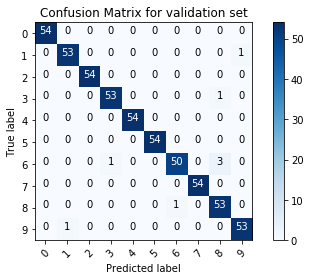

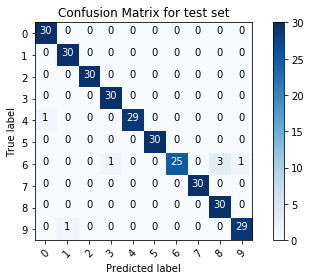

In [32]:
#13
#confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()  
    plt.show()

cm1 = confusion_matrix(y_val, clf.predict(X_val))

plot_confusion_matrix(cm1, unique_labels(y_val),title = "Confusion Matrix for validation set")

cm2 = confusion_matrix(y_test, clf.predict(X_test))

plot_confusion_matrix(cm2, unique_labels(y_test),title = "Confusion Matrix for test set")